<a href="https://colab.research.google.com/github/TriPhan15/K-Means_K-NN/blob/main/K_Means_K_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Cell 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import math
import sys
import io

# HÀM HỖ TRỢ LẤY DỮ LIỆU
def get_data_input():
    print("\n--- CHỌN NGUỒN DỮ LIỆU ---")
    print("1. Tự sinh dữ liệu ngẫu nhiên (Random)")
    print("2. Tải file CSV từ máy tính (Colab Upload)")
    choice = input("Chọn (1 hoặc 2): ")

    if choice == '1':
        return 'random', None
    elif choice == '2':
        print("\nVui lòng chọn file CSV từ máy tính...")
        try:
            from google.colab import files
            uploaded = files.upload()
            if not uploaded: return None, None

            filename = next(iter(uploaded))

            # 1. Đọc file
            df = pd.read_csv(io.BytesIO(uploaded[filename]), header=None)

            print(f"-> Đã tải file: {filename}")
            print("-> Đang làm sạch dữ liệu...")

            # 2. Ép toàn bộ dữ liệu sang số (Numeric)
            df = df.apply(pd.to_numeric, errors='coerce')

            # 3. xóa dòng tiêu đề đi
            df = df.dropna()

            print(f"-> Dữ liệu sau khi làm sạch: {df.shape[0]} dòng.")
            print(df.head(3))

            # 4. Tách X và y
            # Lấy 2 cột đầu làm Features (X)
            X = df.iloc[:, :2].values

            # Lấy cột thứ 3 làm Label (y) nếu có
            if df.shape[1] > 2:
                y = df.iloc[:, 2].values
            else:
                y = None

            return 'file', (X, y)

        except ImportError:
            print("Lỗi: Không thể dùng tính năng upload ngoài Colab.")
            return None, None
        except Exception as e:
            print(f"Lỗi đọc file: {e}")
            return None, None
    else:
        return None, None

# 1. CLASS K-MEANS (Phân cụm)
class KMeansClustering:
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centers = None
        self.labels = None

    def init_centers(self, X):
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]

    def assign_labels(self, X, centers):
        D = cdist(X, centers)
        return np.argmin(D, axis=1)

    def update_centers(self, X, labels):
        centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            Xk = X[labels == k, :]
            if len(Xk) > 0:
                centers[k, :] = np.mean(Xk, axis=0)
            else:
                centers[k, :] = self.centers[k, :]
        return centers

    def has_converged(self, old_centers, new_centers):
        return (set([tuple(a) for a in old_centers]) ==
                set([tuple(a) for a in new_centers]))

    # Hàm tính Inertia
    def calculate_inertia(self, X):
        D = cdist(X, self.centers)
        min_dist = np.min(D, axis=1)
        return np.sum(min_dist**2)

    def fit(self, X, verbose=True):
        if verbose: print(f"\n--- K-MEANS (K={self.n_clusters}) ---")
        self.centers = self.init_centers(X)
        self.labels = np.zeros(X.shape[0])

        for i in range(self.max_iter):
            old_centers = self.centers
            self.labels = self.assign_labels(X, self.centers)
            self.centers = self.update_centers(X, self.labels)

            if verbose:
                print(f"\n>> Bước lặp {i+1}:")
                print(f"   Vị trí tâm cũ: \n{np.round(old_centers, 2)}")
                print(f"   Vị trí tâm mới: \n{np.round(self.centers, 2)}")

            if self.has_converged(old_centers, self.centers):
                if verbose: print(f"-> Hội tụ sau {i+1} bước.")
                break
        if verbose: print("--------------------------------------------------")

    def plot_result(self, X):
        plt.figure(figsize=(8, 6))
        plt.title(f'Kết quả K-Means với K={self.n_clusters}')
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=50, cmap='viridis', label='Data Points', alpha=0.6)
        plt.scatter(self.centers[:, 0], self.centers[:, 1], c='red', s=200, marker='X', label='Centroids')
        plt.legend()
        plt.show()

# 2. CLASS K-NN (Phân loại)
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test, verbose=False):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            distances = np.sqrt(np.sum((self.X_train - X_test[i, :])**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            k_nearest_dists = distances[k_indices]

            if verbose:
                print(f"\n>> Đang phân loại điểm {X_test[i]}:")
                print(f"   {self.k} láng giềng gần nhất có index: {k_indices}")
                print(f"   Khoảng cách tương ứng: {np.round(k_nearest_dists, 2)}")
                print(f"   Nhãn của láng giềng: {k_nearest_labels}")

            counts = np.bincount(k_nearest_labels.astype(int))
            y_pred[i] = np.argmax(counts)

            if verbose:
                print(f"-> Kết quả bầu chọn: Class {int(y_pred[i])}")

        return y_pred

    def plot_result(self, X_test, y_pred, point_new=None):
        plt.figure(figsize=(8, 6))
        plt.title(f'Kết quả phân loại K-NN với K={self.k}')
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], c=self.y_train, s=50, cmap='viridis', alpha=0.6, label='Training Data')

        if point_new is not None:
            plt.scatter(point_new[:, 0], point_new[:, 1], c='red', s=200, marker='*', label='New Point')
            plt.annotate(f"Dự đoán: Lớp {int(y_pred[0])}",
                         (point_new[0,0], point_new[0,1]),
                         xytext=(15,15), textcoords='offset points',
                         bbox=dict(boxstyle="round", fc="w"))

        plt.legend()
        plt.show()

In [5]:
# Cell 2
# 1. HÀM TÌM K CHO K-MEANS (ELBOW METHOD)
def find_best_k_auto(X, max_k=10):
    print(f"\n--- [K-MEANS] ĐANG TÍNH TOÁN TÌM K TỐI ƯU (MAX K={max_k}) ---")
    inertias = []
    K_range = range(1, max_k + 1)

    # Chạy vòng lặp tính Inertia
    for k in K_range:
        model = KMeansClustering(n_clusters=k)
        model.fit(X, verbose=False)
        inertia = model.calculate_inertia(X)
        inertias.append(inertia)

    # Thuật toán hình học tìm điểm Khuỷu tay (Max Distance to Line)
    p1_x, p1_y = 1, inertias[0]
    p2_x, p2_y = max_k, inertias[-1]

    max_dist = 0
    best_k = 1

    for i in range(len(inertias)):
        k_curr = i + 1
        inertia_curr = inertias[i]
        numerator = abs((p2_y - p1_y) * k_curr - (p2_x - p1_x) * inertia_curr + p2_x * p1_y - p2_y * p1_x)
        denominator = math.sqrt((p2_y - p1_y)**2 + (p2_x - p1_x)**2)
        distance = numerator / denominator

        if distance > max_dist:
            max_dist = distance
            best_k = k_curr

    print(f" K TỐI ƯU = {best_k}")

    # Vẽ hình minh họa
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bx-', label='Inertia Curve')
    plt.plot([1, max_k], [inertias[0], inertias[-1]], 'r--', label='Line Start-End', alpha=0.5)
    plt.scatter(best_k, inertias[best_k-1], c='red', s=200, marker='*', label=f'Auto Pick K={best_k}', zorder=5)
    plt.xlabel('K (Số cụm)')
    plt.ylabel('Inertia')
    plt.title(f'Phương pháp Khuỷu tay (Chọn K={best_k})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_k

# 2. HÀM TÌM K CHO K-NN (ERROR RATE)
def find_best_k_knn(X_train, y_train, X_test, y_test, max_k=15):
    print(f"\n--- [K-NN] ĐANG TÍNH TOÁN TÌM K TỐI ƯU (MAX K={max_k}) ---")
    accuracy_scores = []
    # Chỉ chạy K lẻ
    K_range = [k for k in range(1, max_k + 1) if k % 2 != 0]

    for k in K_range:
        knn = KNNClassifier(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test, verbose=False)
        accuracy = np.mean(y_pred == y_test)
        accuracy_scores.append(accuracy)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, accuracy_scores, 'ro-', linewidth=2)
    plt.xlabel('Giá trị K')
    plt.ylabel('Độ chính xác')
    plt.title('Độ chính xác theo từng K')
    plt.grid(True)
    plt.show()

    # Tìm K tốt nhất
    best_k = K_range[np.argmax(accuracy_scores)]
    print(f" K TỐT NHẤT LÀ: {best_k} (Độ chính xác cao nhất).")
    return best_k

1. K-MEANS...

--- CHỌN NGUỒN DỮ LIỆU ---
1. Tự sinh dữ liệu ngẫu nhiên (Random)
2. Tải file CSV từ máy tính (Colab Upload)
Chọn (1 hoặc 2): 2

Vui lòng chọn file CSV từ máy tính...


Saving K_NN-K_Means.csv to K_NN-K_Means (3).csv
-> Đã tải file: K_NN-K_Means (3).csv
-> Đang làm sạch dữ liệu...
-> Dữ liệu sau khi làm sạch: 12 dòng.
     0    1    2
1  1.5  2.5  0.0
2  1.0  3.0  0.0
3  2.0  2.0  0.0
-> Đã lấy dữ liệu X từ file CSV.

--- [K-MEANS] ĐANG TÍNH TOÁN TÌM K TỐI ƯU (MAX K=10) ---
 K TỐI ƯU = 3


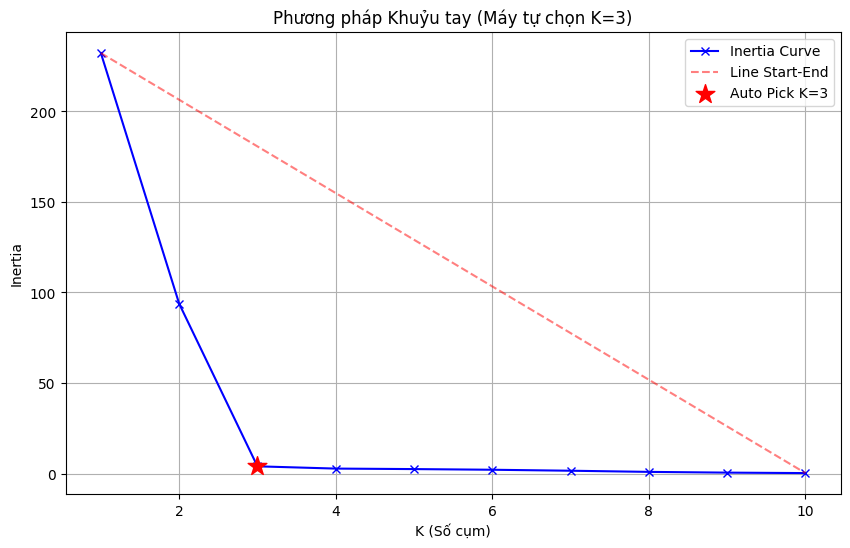


>>> Chạy K-Means thực tế với K=3...

--- K-MEANS (K=3) ---

>> Bước lặp 1:
   Vị trí tâm cũ: 
[[7.5 2.5]
 [8.  2. ]
 [1.8 2.8]]
   Vị trí tâm mới: 
[[8.24 7.36]
 [8.5  1.83]
 [1.58 2.58]]

>> Bước lặp 2:
   Vị trí tâm cũ: 
[[8.24 7.36]
 [8.5  1.83]
 [1.58 2.58]]
   Vị trí tâm mới: 
[[8.43 8.57]
 [8.25 2.  ]
 [1.58 2.58]]

>> Bước lặp 3:
   Vị trí tâm cũ: 
[[8.43 8.57]
 [8.25 2.  ]
 [1.58 2.58]]
   Vị trí tâm mới: 
[[8.43 8.57]
 [8.25 2.  ]
 [1.58 2.58]]
-> Hội tụ sau 3 bước.
--------------------------------------------------


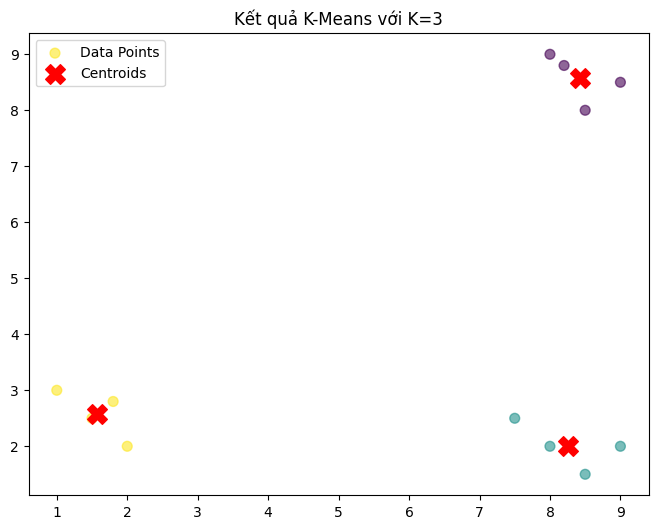



2. K-NN...

--- CHỌN NGUỒN DỮ LIỆU ---
1. Tự sinh dữ liệu ngẫu nhiên (Random)
2. Tải file CSV từ máy tính (Colab Upload)
Chọn (1 hoặc 2): 2

Vui lòng chọn file CSV từ máy tính...


Saving K_NN-K_Means.csv to K_NN-K_Means (4).csv
-> Đã tải file: K_NN-K_Means (4).csv
-> Đang làm sạch dữ liệu...
-> Dữ liệu sau khi làm sạch: 12 dòng.
     0    1    2
1  1.5  2.5  0.0
2  1.0  3.0  0.0
3  2.0  2.0  0.0
-> Đã tách X và y từ file CSV.

--- [K-NN] ĐANG TÍNH TOÁN TÌM K TỐI ƯU (MAX K=15) ---


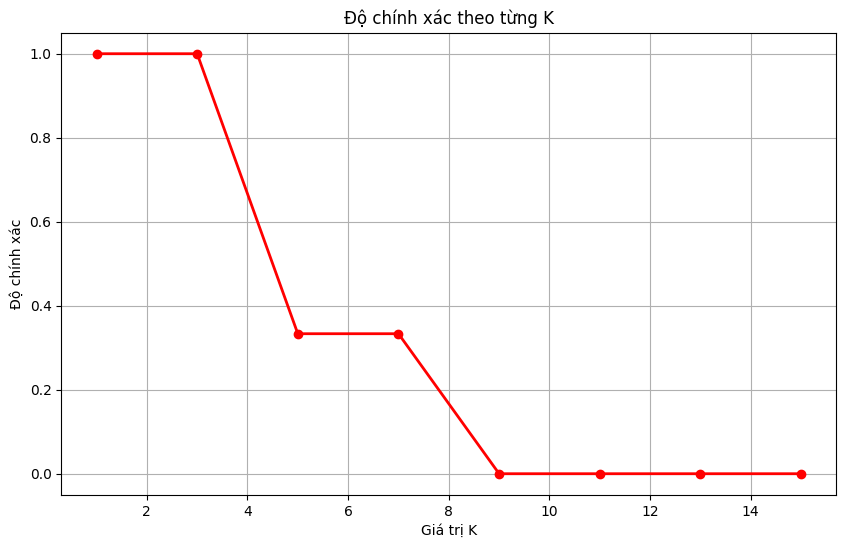

 K TỐT NHẤT LÀ: 1 (Độ chính xác cao nhất).

>>> Đã huấn luyện mô hình K-NN với K=1

------------------------------
NHẬP TỌA ĐỘ ĐIỂM MỚI ĐỂ DỰ ĐOÁN
Nhập tọa độ X: 10
Nhập tọa độ Y: 10

>> Đang tính toán cho điểm [[10. 10.]]...

>> Đang phân loại điểm [10. 10.]:
   1 láng giềng gần nhất có index: [1]
   Khoảng cách tương ứng: [1.8]
   Nhãn của láng giềng: [1.]
-> Kết quả bầu chọn: Class 1


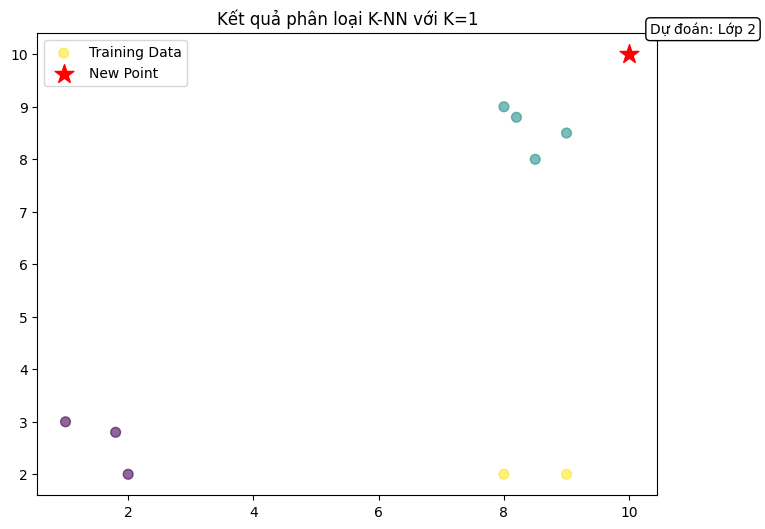

In [9]:
# Cell 3
# PHẦN 1: KIỂM TRA TỰ ĐỘNG K-MEANS
print("1. K-MEANS...")

# Gọi hàm lấy dữ liệu của bạn
source, data_bundle = get_data_input()

X_kmeans = None

if source == 'random':
    print("-> Đang tạo dữ liệu ngẫu nhiên (4 cụm)...")
    X_kmeans, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)

elif source == 'file':
    # K-Means chỉ cần X
    X_kmeans, y_temp = data_bundle
    print("-> Đã lấy dữ liệu X từ file CSV.")

if X_kmeans is not None:
    # 1. Máy tự tìm K tối ưu
    k_auto = find_best_k_auto(X_kmeans, max_k=10)

    # 2. Chạy thuật toán
    print(f"\n>>> Chạy K-Means thực tế với K={k_auto}...")
    kmeans_model = KMeansClustering(n_clusters=k_auto)
    kmeans_model.fit(X_kmeans)
    kmeans_model.plot_result(X_kmeans)
else:
    print("Không có dữ liệu để chạy K-Means.")


print("\n" + "="*50 + "\n")

# PHẦN 2: KIỂM TRA TỰ ĐỘNG K-NN
print("2. K-NN...")

# Gọi hàm lấy dữ liệu lần 2
source, data_bundle = get_data_input()

X_knn, y_knn = None, None

if source == 'random':
    print("-> Đang tạo dữ liệu ngẫu nhiên (3 lớp)...")
    X_knn, y_knn = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

elif source == 'file':
    X_knn, y_knn = data_bundle

    if y_knn is None:
        print(" Lỗi: File CSV cho K-NN cần ít nhất 3 cột (2 cột tọa độ X + 1 cột nhãn y).")
        X_knn = None
    else:
        print("-> Đã tách X và y từ file CSV.")

if X_knn is not None and y_knn is not None:
    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

    # 1. Máy tự tìm K tối ưu
    best_k_knn = find_best_k_knn(X_train, y_train, X_test, y_test, max_k=15)

    # 2. Huấn luyện mô hình với K tốt nhất
    print(f"\n>>> Đã huấn luyện mô hình K-NN với K={best_k_knn}")
    knn_model = KNNClassifier(k=best_k_knn)
    knn_model.fit(X_train, y_train)

    print("\n" + "-"*30)
    print("NHẬP TỌA ĐỘ ĐIỂM MỚI ĐỂ DỰ ĐOÁN")
    try:
        x_input = float(input("Nhập tọa độ X: "))
        y_input = float(input("Nhập tọa độ Y: "))

        # Tạo điểm mới từ input
        new_point = np.array([[x_input, y_input]])

        print(f"\n>> Đang tính toán cho điểm {new_point}...")

        # Dự đoán (Có in step-by-step nhờ verbose=True)
        knn_model.predict(new_point, verbose=True)

        knn_model.plot_result(X_test, knn_model.predict(X_test), point_new=new_point)

    except ValueError:
        print("Lỗi: Vui lòng nhập số hợp lệ!")

else:
    print("Không có đủ dữ liệu để chạy K-NN.")

--- K-MEANS ---

--- CHỌN NGUỒN DỮ LIỆU ---
1. Tự sinh dữ liệu ngẫu nhiên (Random)
2. Tải file CSV từ máy tính (Colab Upload)
Chọn (1 hoặc 2): 2

Vui lòng chọn file CSV từ máy tính...


Saving K_NN-K_Means.csv to K_NN-K_Means (5).csv
-> Đã tải file: K_NN-K_Means (5).csv
-> Đang làm sạch dữ liệu...
-> Dữ liệu sau khi làm sạch: 12 dòng.
     0    1    2
1  1.5  2.5  0.0
2  1.0  3.0  0.0
3  2.0  2.0  0.0
Nhập số cụm K muốn chia (ví dụ 3): 3

--- K-MEANS (K=3) ---

>> Bước lặp 1:
   Vị trí tâm cũ: 
[[8.  2. ]
 [7.5 2.5]
 [8.5 8. ]]
   Vị trí tâm mới: 
[[8.5  1.83]
 [2.76 2.56]
 [8.43 8.57]]

>> Bước lặp 2:
   Vị trí tâm cũ: 
[[8.5  1.83]
 [2.76 2.56]
 [8.43 8.57]]
   Vị trí tâm mới: 
[[8.25 2.  ]
 [1.58 2.58]
 [8.43 8.57]]

>> Bước lặp 3:
   Vị trí tâm cũ: 
[[8.25 2.  ]
 [1.58 2.58]
 [8.43 8.57]]
   Vị trí tâm mới: 
[[8.25 2.  ]
 [1.58 2.58]
 [8.43 8.57]]
-> Hội tụ sau 3 bước.
--------------------------------------------------


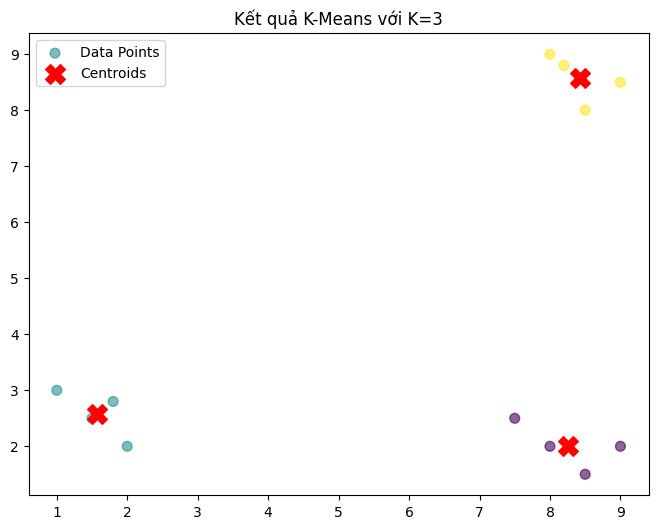

In [10]:
# Cell 4
# === CELL CHẠY K-MEANS ===
print("--- K-MEANS ---")
source, data = get_data_input()

if source:
    if source == 'random':
        print("Đang tạo dữ liệu ngẫu nhiên...")
        X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)
    elif source == 'file':
        X, _ = data

    try:
        k_input = int(input("Nhập số cụm K muốn chia (ví dụ 3): "))
        model = KMeansClustering(n_clusters=k_input)
        model.fit(X)
        model.plot_result(X)
    except ValueError:
        print("Lỗi nhập liệu! Vui lòng chạy lại cell này.")
else:
    print("Bạn chưa chọn dữ liệu. Hãy chạy lại cell.")

--- K-NN ---

--- CHỌN NGUỒN DỮ LIỆU ---
1. Tự sinh dữ liệu ngẫu nhiên (Random)
2. Tải file CSV từ máy tính (Colab Upload)
Chọn (1 hoặc 2): 2

Vui lòng chọn file CSV từ máy tính...


Saving K_NN-K_Means.csv to K_NN-K_Means (9).csv
Đã tải file: K_NN-K_Means (9).csv
     x    y  label
0  1.5  2.5      0
1  1.0  3.0      0
2  2.0  2.0      0
3  1.8  2.8      0
4  8.5  8.0      1
Nhập số láng giềng K (ví dụ 3): 3

--- NHẬP ĐIỂM CẦN DỰ ĐOÁN ---
Nhập x: 10
Nhập y: 10


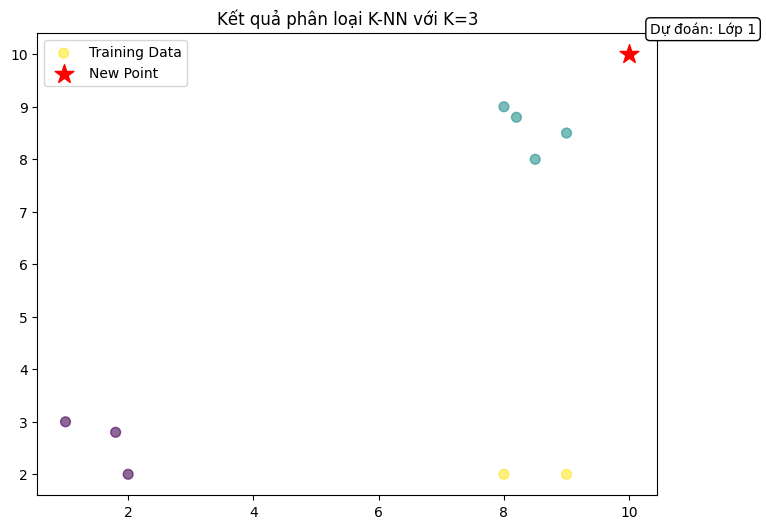

In [ ]:
# Cell 5
# === CELL CHẠY K-NN ===
print("--- K-NN ---")
source, data = get_data_input()

if source:
    if source == 'random':
        X, y = make_blobs(n_samples=200, centers=3, cluster_std=1.0, random_state=42)
    elif source == 'file':
        X, y = data
        if y is None:
            print("Lỗi: File CSV không có cột nhãn (Label)!")
            X = None # Reset

    if X is not None:
        # Chia train/test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        try:
            k_input = int(input("Nhập số láng giềng K (ví dụ 3): "))
            knn = KNNClassifier(k=k_input)
            knn.fit(X_train, y_train)

            print("\n--- NHẬP ĐIỂM CẦN DỰ ĐOÁN ---")
            x_coord = float(input("Nhập x: "))
            y_coord = float(input("Nhập y: "))
            new_point = np.array([[x_coord, y_coord]])

            prediction = knn.predict(new_point, verbose=True)
            knn.plot_result(X_test, prediction, point_new=new_point)

        except ValueError:
            print("Lỗi nhập liệu! Vui lòng chạy lại cell này.")
else:
    print("Bạn chưa chọn dữ liệu.")